<a href="https://colab.research.google.com/github/Bubukisapisa/ML_education/blob/main/%22HW_2_2_%D0%9B%D0%BE%D0%B3%D1%96%D1%81%D1%82%D0%B8%D1%87%D0%BD%D0%B0_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%96%D1%8F_%D0%B7_scikit_learn_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle) Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [1]:
!pip install opendatasets --upgrade --quiet
!pip install pyarrow --quiet

In [49]:
import opendatasets as od
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
import joblib

In [3]:
od.version()

'0.1.22'

In [4]:
data_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-3/data?select=train.csv'

In [5]:
od.download(data_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: lacoppo
Your Kaggle Key: ··········


100%|██████████| 637k/637k [00:00<00:00, 481MB/s]


Extracting archive ./bank-customer-churn-prediction-dlu-course-c-3/bank-customer-churn-prediction-dlu-course-c-3.zip to ./bank-customer-churn-prediction-dlu-course-c-3


In [6]:
data_dir = './bank-customer-churn-prediction-dlu-course-c-3'
os.listdir(data_dir)

['test.csv', 'sample_submission.csv', 'train.csv']

In [7]:
df = pd.read_csv(data_dir + '/train.csv')
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [8]:
df_train, df_valid = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Exited'])

In [9]:
print(df_train.shape)
print(df_valid.shape)

(12000, 14)
(3000, 14)


2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [10]:
input_cols = df.columns[2:-1]
target_col = df.columns[-1]

train_inputs = df_train[input_cols]
train_targets = df_train[target_col]

val_inputs = df_valid[input_cols]
val_targets = df_valid[target_col]

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [11]:
numeric_cols = df.select_dtypes('number').columns[2:-1]
categorical_cols = df.select_dtypes('object').columns

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [12]:
df_train[numeric_cols].describe().round(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00
mean,658.84,37.69,5.03,43008.17,1.59,0.79,0.49,117992.40
std,72.33,8.14,2.78,59906.63,0.53,0.41,0.50,45589.48
min,431.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58
25%,603.00,32.00,3.00,0.00,1.00,1.00,0.00,83343.73
50%,661.00,37.00,5.00,0.00,2.00,1.00,0.00,123613.91
75%,708.00,42.00,7.00,109949.05,2.00,1.00,1.00,156912.81
max,850.00,74.00,10.00,209767.31,4.00,1.00,1.00,199992.48


In [13]:
df_train.isna().sum()

,0
id,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


Пстих значень нема, заповнювати нічого непотрібно.

In [14]:
df_train[numeric_cols].nunique()

,0
CreditScore,373
Age,56
Tenure,11
Balance,2895
NumOfProducts,4
HasCrCard,2
IsActiveMember,2
EstimatedSalary,5502


In [15]:
#масштабую дані
num_for_scale = numeric_cols[:5].tolist()+numeric_cols[-1::].tolist()
scaler = MinMaxScaler()

scaler.fit(train_inputs[num_for_scale])

MinMaxScaler()

In [16]:
train_inputs[num_for_scale] = scaler.transform(train_inputs[num_for_scale])
val_inputs[num_for_scale] = scaler.transform(val_inputs[num_for_scale])

/tmp/ipython-input-3250970384.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_inputs[num_for_scale] = scaler.transform(train_inputs[num_for_scale])
/tmp/ipython-input-3250970384.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_inputs[num_for_scale] = scaler.transform(val_inputs[num_for_scale])


In [17]:
train_inputs['HasCrCard'] = train_inputs['HasCrCard'].astype('int64')
train_inputs['IsActiveMember'] = train_inputs['IsActiveMember'].astype('int64')

/tmp/ipython-input-2272840067.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_inputs['HasCrCard'] = train_inputs['HasCrCard'].astype('int64')
/tmp/ipython-input-2272840067.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_inputs['IsActiveMember'] = train_inputs['IsActiveMember'].astype('int64')


In [18]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [83]:
encoder.fit(train_inputs[['Geography']])

encoded_cols = list(encoder.get_feature_names_out(['Geography']))

train_inputs[encoded_cols] = encoder.transform(train_inputs[['Geography']])
val_inputs[encoded_cols] = encoder.transform(val_inputs[['Geography']])

encoded_cols

['Geography_France', 'Geography_Germany', 'Geography_Spain']

In [20]:
train_inputs['Gender'] = train_inputs['Gender'].replace({'Male': 1, 'Female': 0})
val_inputs['Gender'] = val_inputs['Gender'].replace({'Male': 1, 'Female': 0})

/tmp/ipython-input-1309338584.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_inputs['Gender'] = train_inputs['Gender'].replace({'Male': 1, 'Female': 0})
/tmp/ipython-input-1309338584.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_inputs['Gender'] = val_inputs['Gender'].replace({'Male': 1, 'Female': 0})


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [21]:
train_inputs.to_parquet('train_inputs.parquet')
val_inputs.to_parquet('val_inputs.parquet')

In [22]:
%%time
pd.DataFrame(train_targets).to_parquet('train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('val_targets.parquet')

CPU times: user 8.59 ms, sys: 721 µs, total: 9.31 ms
Wall time: 10 ms


6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [23]:
col_for_model = ['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
                 'Geography_France',	'Geography_Germany',	'Geography_Spain'
                 ]
X_train = pd.read_parquet('train_inputs.parquet')[col_for_model]
X_val = pd.read_parquet('val_inputs.parquet')[col_for_model]

In [24]:
lin_reg = LogisticRegression(solver = 'liblinear')

In [25]:
lin_reg.fit(X_train, train_targets)

LogisticRegression(solver='liblinear')

In [26]:
train_pred = lin_reg.predict(X_train)

In [27]:
train_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [28]:
accuracy_score(train_targets, train_pred)

0.87425

In [29]:
val_pred = lin_reg.predict(X_val)

In [30]:
accuracy_score(val_targets, val_pred)

0.8716666666666667

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [31]:
confm_train = confusion_matrix(train_targets, train_pred, normalize = 'true')
confm_train

array([[0.9601381 , 0.0398619 ],
       [0.46191646, 0.53808354]])

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

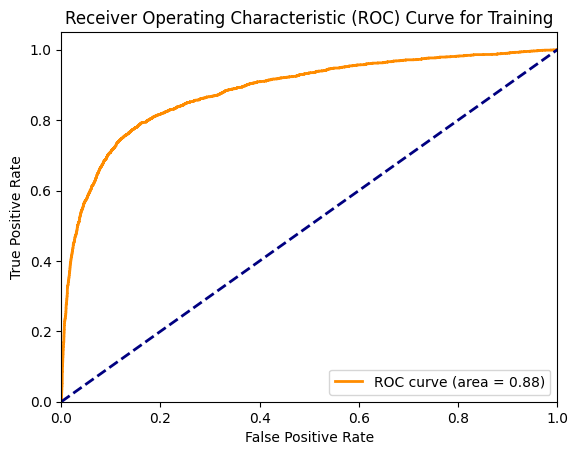

In [33]:
train_pred_proba = lin_reg.predict_proba(X_train)[:, 1]

fpr, tpr, thresholds = roc_curve(train_targets, train_pred_proba, pos_label=1.0)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve for Training')
plt.legend(loc="lower right")
plt.show()

In [34]:
f1_score(train_targets, train_pred, pos_label=1.0)

0.6352429296591733

##Підсумок по показникам
Confusion matrix показує що модель гарно прогнозує цільовий показник (93%) але значно гірше негативні значення (53%)

Accuracy score достатньо хороший 87%, що теж свідчить про якість моделі.
AUROC становить 88% - це теж гарний показник який показує що з високою вірогідністю модель спрогнозує позитивне значення цільовому показнику 1.

Та і по дузі ROC curve видно що значення стрімко зростає, тобто при різних порогових значеннях модель гарно прогнозує true positive value.

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [48]:
train_major_pred = np.zeros(len(train_targets))
val_major_pred = np.zeros(len(val_targets))
train_major_acc = accuracy_score(train_targets, train_major_pred)
val_major_acc = accuracy_score(val_targets, val_major_pred)

print(f'train accuracy score is {train_major_acc}')
print(f'validate accuracy score is {val_major_acc}')

train accuracy score is 0.7965
validate accuracy score is 0.7966666666666666


## Пункт 8 підсумок
Враховуючи результат коли всі значення передбачень задаються як 0 то модель впоралась краще проте, недостатньо (79% vs 87%)

Хотілося б бачити результат 95%+

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [54]:
#не додавав більше нічого бо нічого не запаковував у функції
log_reg_data = {
    'model': lin_reg

}

joblib.dump(log_reg_data, 'log_reg.joblib')

['log_reg.joblib']

In [53]:
model_2 = joblib.load('log_reg.joblib')
model_2['model'].predict(X_train)

array([0., 0., 0., ..., 0., 0., 0.])

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [96]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
  num_for_scale = numeric_cols[:5].tolist()+numeric_cols[-1::].tolist()
  input_df[num_for_scale] = scaler.transform(input_df[num_for_scale])
  encoded_cols = list(encoder.get_feature_names_out(['Geography']))
  input_df[encoded_cols] = encoder.transform(input_df[['Geography']])
  input_df[['Gender']] = input_df[['Gender']].replace({'Male': 1, 'Female': 0})



  X_input = input_df[col_for_model]
  prob = lin_reg.predict_proba(X_input)[:,1]
  return prob

In [97]:
predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, df[:5])

array([0.02722238, 0.02233686, 0.07410028, 0.11842913, 0.24143218])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [98]:
test_raw_df = pd.read_csv(data_dir + '/test.csv')

In [99]:
test_raw_df['Exited'] = predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, test_raw_df)

In [100]:
test_raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Exited
0,15000,15594796.0,Chu,0.365155,Germany,1,0.214286,0.2,0.696265,0.000000,1.0,1.0,0.789477,0.0,1.0,0.0,0.075341
1,15001,15642821.0,Mazzi,0.286396,France,1,0.375000,0.5,0.000000,0.333333,1.0,1.0,0.337131,1.0,0.0,0.0,0.035385
2,15002,15716284.0,Onyekachi,0.656325,France,1,0.446429,0.8,0.000000,0.333333,1.0,0.0,0.783859,1.0,0.0,0.0,0.152962
3,15003,15785078.0,Martin,0.682578,Spain,1,0.482143,0.3,0.000000,0.000000,1.0,1.0,0.834571,0.0,0.0,1.0,0.194683
4,15004,15662955.0,Kenechukwu,0.384248,Spain,1,0.446429,0.8,0.000000,0.333333,1.0,1.0,0.718421,0.0,0.0,1.0,0.055614


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [104]:
sample_sub = pd.read_csv(data_dir + '/sample_submission.csv')

sample_sub = sample_sub.merge(test_raw_df[["id", "Exited"]], on="id", how="left", suffixes=("", "_new"))
sample_sub["Exited"] = sample_sub["Exited_new"]
sample_sub = sample_sub.drop(columns="Exited_new")

sample_sub.head()



,id,Exited
0,15000,0.075341
1,15001,0.035385
2,15002,0.152962
3,15003,0.194683
4,15004,0.055614


In [105]:
sample_sub.to_csv("submission_log_reg.csv", index=False, encoding="utf-8")